In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.states import Statevector, partial_trace
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_state_qsphere, plot_state_city
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute
from qiskit.circuit.add_control import add_control
import numpy as np

Here I'm training on Stean [7,1,3]-code (in stabiliser formalism)

*initializing

*adding error

*syndrom finding

*mearsument

*correction erros

In [ ]:
# Need to write function for general measurement scheme

In [2]:
def initialize_qubit(given_circuit, qubit_index):
    
    custom_state = [np.sqrt(0.7), np.sqrt(0.3)]
    given_circuit.initialize(custom_state, qubit_index)
    
    return given_circuit

In [2]:
# K1 = IIIXXXX
# K2 = XIXIXIX
# K3 = IXXIIXX
# K4 = IIIZZZZ
# K5 = ZIZIZIZ
# K6 = IZZIIZZ

Stabilizers = {
    "K1": {"X": [3, 4, 5, 6], "Y": [], "Z": []},
    "K2": {"X": [0, 2, 4, 6], "Y": [], "Z": []},
    "K3": {"X": [1, 2, 5, 6], "Y": [], "Z": []},
    "K4": {"X": [], "Y": [], "Z": [3, 4, 5, 6]},
    "K5": {"X": [], "Y": [], "Z": [0, 2, 4, 6]},
    "K6": {"X": [], "Y": [], "Z": [1, 2, 5, 6]},
}

# Lookuptable = {
#     0: {"value": [4,5,6],
#         0: {"value": [4,5],
#             0: {"value": [6]},
#             1: {"value": []}
#         },
#         1: {"value": [6],
#             0: {"value": [5]},
#             1: {"value": [4]}
#         }
#     },
#     1: {"value": [0,1,2,3],
#         0: {"value": [1,2],
#             0: {"value": [3]},
#             1: {"value": [0]}
#         },
#         1: {"value": [0,3],
#             0: {"value": [2]},
#             1: {"value": [1]}
#         }
#     }
# }

Lookuptable = [
    "010",
    "001",
    "011",
    "100",
    "110",
    "101",
    "111"
]

In [106]:
# create LOOKUPTABLE
def sngl_er_lookuptable(numb_qubits):

    Lookup_matrix = np.zeros((2*numb_qubits, len(Stabilizers)), dtype=int)
    for i in range(len(Stabilizers)):
        a = Stabilizers[f'K{1+i}']["X"]
        b = Stabilizers[f'K{1+i}']["Z"]
        if len(a) != 0:
            for j in a:
                Lookup_matrix[j][i] = 1
        if len(b) != 0:
            for j in b:
                Lookup_matrix[numb_qubits + j][i] = 1

    lookuptable = {'Error': 'Syndrome'}
    for i in range(numb_qubits):
        lookuptable[f'Z{i}'] = list(Lookup_matrix[i])
    for i in range(numb_qubits):
        lookuptable[f'X{i}'] = list(Lookup_matrix[numb_qubits + i])
    
    return lookuptable

sngl_er_lookuptable(7)

{'Error': 'Syndrome',
 'Z0': [0, 1, 0, 0, 0, 0],
 'Z1': [0, 0, 1, 0, 0, 0],
 'Z2': [0, 1, 1, 0, 0, 0],
 'Z3': [1, 0, 0, 0, 0, 0],
 'Z4': [1, 1, 0, 0, 0, 0],
 'Z5': [1, 0, 1, 0, 0, 0],
 'Z6': [1, 1, 1, 0, 0, 0],
 'X0': [0, 0, 0, 0, 1, 0],
 'X1': [0, 0, 0, 0, 0, 1],
 'X2': [0, 0, 0, 0, 1, 1],
 'X3': [0, 0, 0, 1, 0, 0],
 'X4': [0, 0, 0, 1, 1, 0],
 'X5': [0, 0, 0, 1, 0, 1],
 'X6': [0, 0, 0, 1, 1, 1]}

In [3]:
# CORRECTION
def correction_z(circuit, creg):

    # for i in range(len(Lookuptable)):
    #     qcirc.z(i).c_if(clbits_z, eval("0b"+Lookuptable[i]))
    with circuit.if_test((creg[0], 0)) as else_:
        with circuit.if_test((creg[1], 0)):
            with circuit.if_test((creg[2], 1)):
                circuit.z(1)
        with circuit.if_test((creg[1], 1)):
            with circuit.if_test((creg[2], 0)):
                circuit.z(0)
            with circuit.if_test((creg[2], 1)):
                circuit.z(2)
    with else_:
        with circuit.if_test((creg[1], 0)):
            with circuit.if_test((creg[2], 0)):
                circuit.z(3)
            with circuit.if_test((creg[2], 1)):
                circuit.z(5)
        with circuit.if_test((creg[1], 1)):
            with circuit.if_test((creg[2], 0)):
                circuit.z(4)
            with circuit.if_test((creg[2], 1)):
                circuit.z(6)

    return circuit


def correction_x(circuit, creg):

    # for i in range(len(Lookuptable)):
    #     qcirc.x(i).c_if(clbits_x, eval("0b"+Lookuptable[i]))
    with circuit.if_test((creg[0], 0)) as else_:
        with circuit.if_test((creg[1], 0)):
            with circuit.if_test((creg[2], 1)):
                circuit.x(1)
        with circuit.if_test((creg[1], 1)):
            with circuit.if_test((creg[2], 0)):
                circuit.x(0)
            with circuit.if_test((creg[2], 1)):
                circuit.x(2)
    with else_:
        with circuit.if_test((creg[1], 0)):
            with circuit.if_test((creg[2], 0)):
                circuit.x(3)
            with circuit.if_test((creg[2], 1)):
                circuit.x(5)
        with circuit.if_test((creg[1], 1)):
            with circuit.if_test((creg[2], 0)):
                circuit.x(4)
            with circuit.if_test((creg[2], 1)):
                circuit.x(6)

    return circuit


In [4]:
# creating STABILIZER
@staticmethod
def stabilizer(qcirc, stblzr_name, ctrl_index):
    
    X = Stabilizers[stblzr_name]["X"]
    Y = Stabilizers[stblzr_name]["Y"]
    Z = Stabilizers[stblzr_name]["Z"]
    if len(X) != 0:
        qcirc.cx(ctrl_index, X)
    if len(Y) != 0:
        qcirc.cy(ctrl_index, Y)
    if len(Z) != 0:
        qcirc.cz(ctrl_index, Z)
    qcirc.barrier() 

    return qcirc
    

In [5]:
# state PREPARATION
def initialize_qubit(qc1, cl_p, num_qubits, num_anclq):

    qc1.h(range(num_qubits, num_qubits + num_anclq))
    for i in range(num_anclq):
        stabilizer(qc1, f'K{1+i}', num_qubits + i)      # X-stabilizers
    qc1.h(range(num_qubits, num_qubits + num_anclq))
    qc1.measure([7, 8, 9], [7, 8, 9])     # Measurement M{1-3}
    correction_z(qc1, cl_p)     # Correction_Z

    return qc1

In [83]:
def check(qcirc):
    statevect = execute(qcirc, Aer.get_backend('statevector_simulator'), shots=1000).result().get_statevector()
    counts = statevect.sample_counts(shots=10000)
    plot_histogram(counts)

In [9]:
num_qubits = 7
phys_qubits = QuantumRegister(num_qubits, 'q')
num_anclq = 3
prepare_q = QuantumRegister(num_anclq, 'p')
ancila_z = QuantumRegister(num_anclq, 'a_z')
ancila_x = QuantumRegister(num_anclq, 'a_x')
cl_data = ClassicalRegister(num_qubits, 'c_data')
cl_p = ClassicalRegister(num_anclq, 'c_p')
cl_z = ClassicalRegister(num_anclq, 'c_z')
cl_x = ClassicalRegister(num_anclq, 'c_x')
qc = QuantumCircuit(phys_qubits, prepare_q, ancila_z, ancila_x, cl_data, cl_p, cl_z, cl_x)
# qc = QuantumCircuit(phys_qubits, prepare_q, cl_data, cl_p)

# -----------------------------Initialization
# data = Statevector.from_label('0000000')
# anc_z_state = Statevector.from_label('000')
# anc_x_state = Statevector.from_label('000')
initialize_qubit(qc, cl_p, num_qubits, num_anclq)
# statevect = execute(qc, Aer.get_backend('statevector_simulator'), shots=1000).result().get_statevector()
# counts = statevect.sample_counts(shots=10000)
# plot_histogram(counts)
qc.barrier() 

#------------------------------ERROR
qc.x(3)
qc.barrier() 

#------------------------------CORRECTION
qc.h(range(num_qubits + num_anclq, num_qubits + 2*num_anclq))

# X-stabilizers
for i in range(num_anclq):
    stabilizer(qc, f'K{1+i}', num_qubits + num_anclq + i)

qc.h(range(num_qubits + num_anclq, num_qubits + 2*num_anclq))

# Measurement M{1-3}
qc.measure(ancila_z, cl_z)

# Correction_Z
correction_z(qc, cl_z)
qc.barrier() 

#---------------------------------------------
qc.h(range(num_qubits + 2*num_anclq, num_qubits + 3*num_anclq))

# Z-stabilizers
for i in range(num_anclq, 2*num_anclq):
    stabilizer(qc, f'K{1+i}', num_qubits + num_anclq + i)

qc.h(range(num_qubits + 2*num_anclq, num_qubits + 3*num_anclq))

# Measurement M{4-6}
qc.measure(ancila_x, cl_x)

# Correction_X
correction_x(qc, cl_x)
qc.barrier() 
#---------------------------------------------

qc.measure(phys_qubits, cl_data)
# vec = qc.save_statevector(qc)

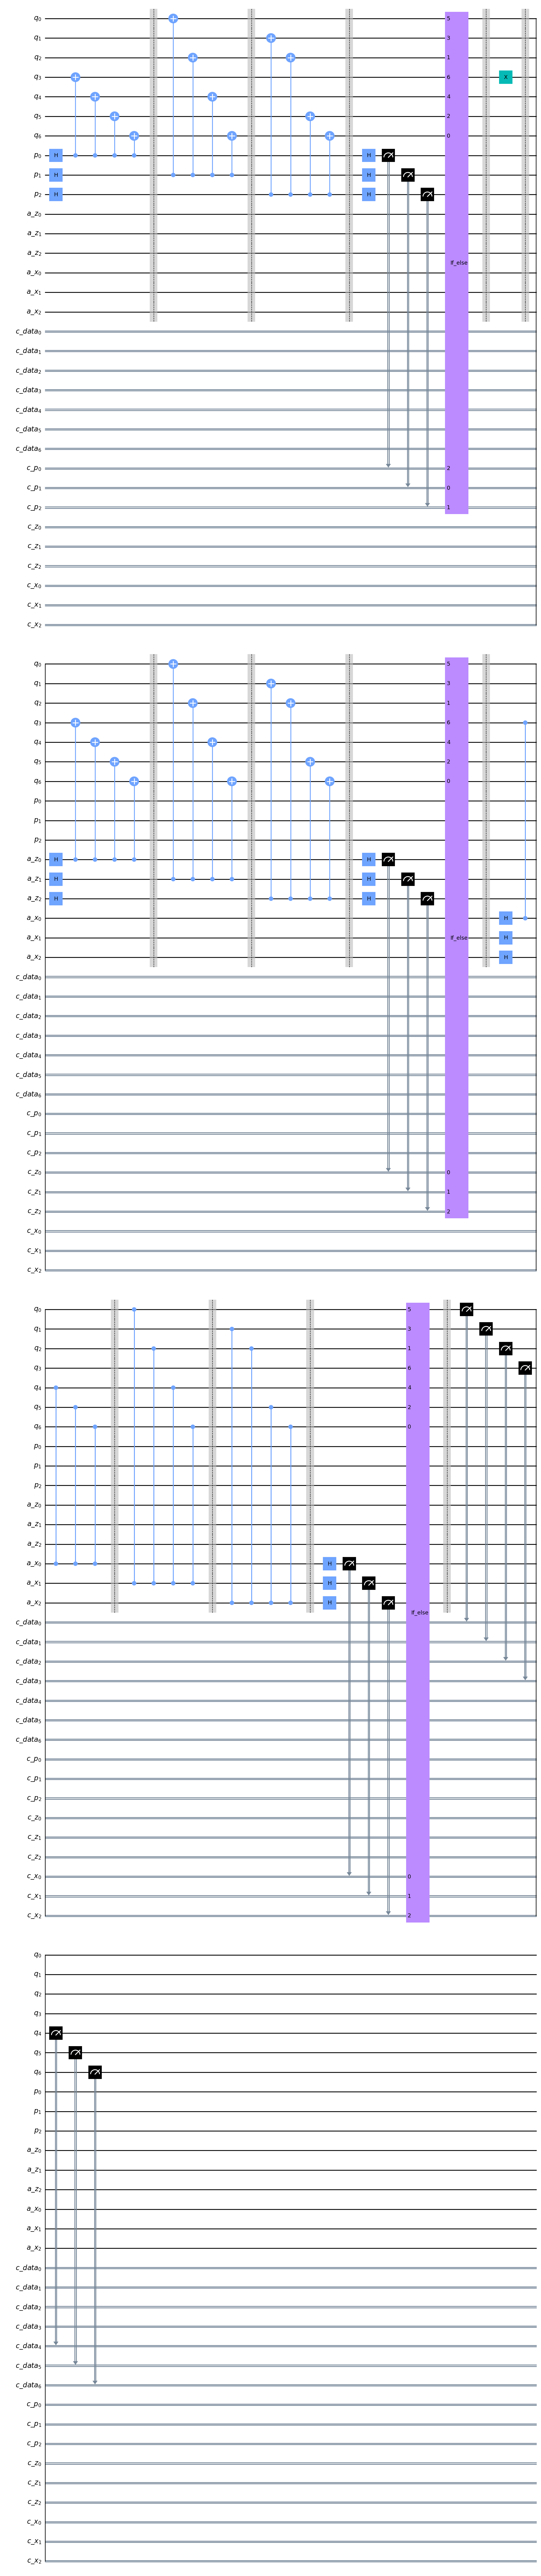

In [10]:
qc.draw('mpl')

In [11]:
backend = Aer.get_backend('aer_simulator_statevector')
circuit_transpiled = transpile(qc, backend)
job = backend.run(circuit_transpiled, shots=10000, dynamic=True)

In [23]:
result = job.result().get_counts(qc)
arr = list(set([elem[::-1][:7] for elem in list(result.keys())]))
print(arr)

['1101001', '1011010', '1100110', '0001111', '0000000', '0110011', '1010101', '0111100']


In [63]:
result = job.result().get_statevector(qc)
reduced_state = partial_trace(result, range(7,16))

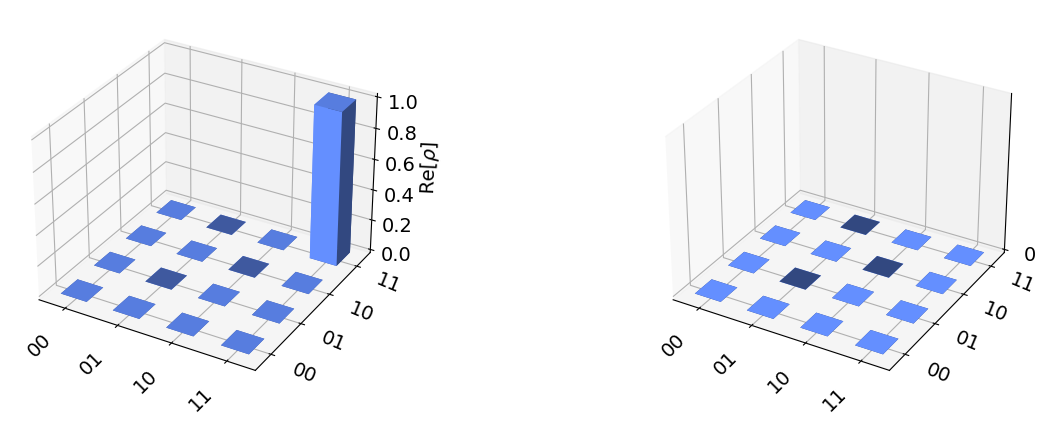

In [13]:
qreg = QuantumRegister(7)
creg = ClassicalRegister(7)
circuit = QuantumCircuit(qreg, creg)

circuit.x(1)
circuit.measure(qreg, creg)
with circuit.if_test((creg[0], 0)) as else_:
    with circuit.if_test((creg[1], 0)):
        with circuit.if_test((creg[2], 1)):
            circuit.x(1)
    with circuit.if_test((creg[1], 1)):
        with circuit.if_test((creg[2], 0)):
            circuit.x(0)
        with circuit.if_test((creg[2], 1)):
            circuit.x(2)
with else_:
    with circuit.if_test((creg[1], 0)):
        with circuit.if_test((creg[2], 0)):
            circuit.x(3)
        with circuit.if_test((creg[2], 1)):
            circuit.x(5)
    with circuit.if_test((creg[1], 1)):
        with circuit.if_test((creg[2], 0)):
            circuit.x(4)
        with circuit.if_test((creg[2], 1)):
            circuit.x(6)
    
circuit.measure(qreg, creg)

circuit.save_statevector()

backend = Aer.get_backend('aer_simulator_statevector')
circuit_transpiled = transpile(circuit, backend)
job = backend.run(circuit_transpiled, shots=1000, dynamic=True)
result = job.result().get_statevector(circuit)
# result = job.result().get_counts(0)
# counts = result.sample_counts(shots=10000)
# plot_histogram(result)
# print(result.get_counts(0))
# circuit.draw('mpl')
reduced_state = partial_trace(result, range(2,7))
plot_state_city(reduced_state.data)

In [ ]:
Lookuptable = {
    "X1": [0,0,1],
    "X0": [0,1,0],
    "X2": [0,1,1],
    "X3": [1,0,0],
    "X5": [1,0,1],
    "X4": [1,1,0],
    "X6": [1,1,1]
}